<a href="https://colab.research.google.com/github/sherlockieee/cs166/blob/main/final_project/CS166_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import logging, sys
import scipy.stats as st

#change level to logging.INFO for running information
logger = logging.getLogger('my_logger')
logging.basicConfig(level=logging.FATAL, format='ID:%(process)d - %(levelname)s - %(message)s')
logger.debug('This WILL get logged')

seed = 2021
random.seed(seed)
np.random.seed(seed)


## Parameters

In [ ]:
#number of nodes in network
n = 50
#average number of edges for each node
m = 5
#maximum edge weight
w_max = 100

#farm waste capacity range
average_waste_lower, average_waste_upper = 100, 500

#farm standard deviation range
std_waste_lower, std_waste_upper = 1, 50

#maximum fuel capacity and maximum waste capacity
max_fuel = 1000
max_waste = 3000

## Implementation

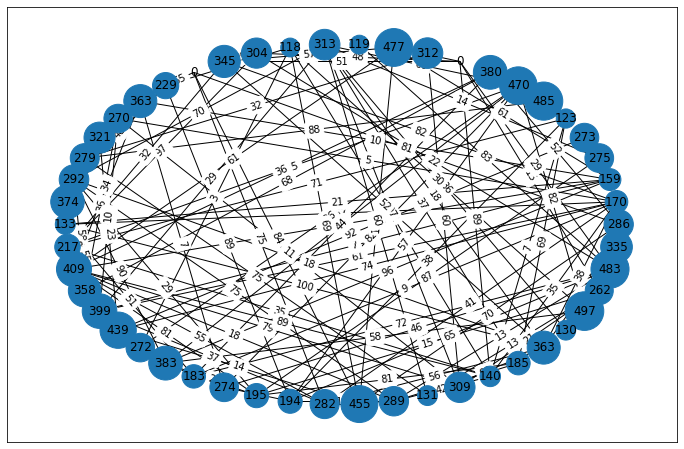

[(9, 11, 86), (9, 15, 48), (9, 16, 51), (9, 42, 89), (9, 47, 15), (9, 48, 29)]
{'mean': 275, 'std': 48, 'is_farm': True, 'is_dropoff': False, 'is_fuel_station': False, 'waste': 236.2870009723707}
100


In [ ]:

class Network:
    '''
    Store the network graph in the waste removal system.

    Parameters
    ----------
    n : int
        The number of nodes/ places in the network
    m: int
        The average number of edges for each node
    w_max: int
        The maximum weight between two edges
    seed: int
        The seed value for replicability

    Attributes
    ----------
    G: networkx.graph
        The network graph. Each node contains the mean, standard deviation,
        is_farm, is_dropoff, is_fuel_station, and waste attribute.
    dropoff_node_idx: int
        The index of the node that is the dropoff station
    fuel_station_node_idx: int
        The index of the node that is the fuel station
    '''

    def __init__(self, n = n, m = m, w_max = w_max, seed = seed):
        #Erdos-renyi random graph
        self.G = nx.erdos_renyi_graph(n, m/(n - 1), seed = seed)
        #make sure the network is always connected
        while not nx.is_connected(self.G):
            self.G = nx.erdos_renyi_graph(n, m/(n - 1), seed = seed)

        #randomize weights
        for (u, v) in self.G.edges():
            self.G.edges[u,v]['weight'] = random.randint(1, w_max)

        #set attribute for each node
        for node_idx in self.G.nodes():
            node = self.G.nodes[node_idx]
            node["mean"] = random.randint(average_waste_lower, average_waste_upper)
            node["std"] = random.randint(std_waste_lower, std_waste_upper)
            node["is_farm"] = True
            node["is_dropoff"] = False
            node["is_fuel_station"] = False
            logger.info(node)

        #choose 2 random nodes to be the dropoff site and fuel site
        self.dropoff_node_idx, self.fuel_station_node_idx = random.sample(set(self.G.nodes()), 2)
        dropoff_node = self.G.nodes[self.dropoff_node_idx]
        dropoff_node["mean"] = 0
        dropoff_node["std"] = 0
        dropoff_node["is_farm"] = False
        dropoff_node["is_dropoff"] = True

        fuel_station_node = self.G.nodes[self.fuel_station_node_idx]
        fuel_station_node["mean"] = 0
        fuel_station_node["std"] = 0
        fuel_station_node["is_farm"] = False
        fuel_station_node["is_fuel_station"] = True

        self.update_daily_waste()


    def get_dist_to_dropoff(self, node_idx):
        '''
        Get distance from any node to dropoff site

        Parameters
        ----------
        node_idx: int
            The index of the node from which we want to get the distance to the dropoff site

        Returns
        ----------
        int
            The shortest distance to the dropoff site
        '''
        return nx.dijkstra_path_length(self.G, node_idx, self.dropoff_node_idx)


    def get_dist_to_fuel(self, node_idx):
        '''
        Get distance from any node to fuel station

        Parameters
        ----------
        node_idx: int
            The index of the node from which we want to get the distance to the fuel station

        Returns
        ----------
        int
            The shortest distance to the fuel station
        '''
        return nx.dijkstra_path_length(self.G, node_idx, self.fuel_station_node_idx)

    
    def get_dist_between_nodes(self, node_1, node_2):
        '''
        Get distance between any two nodes

        Parameters
        ----------
        node_1: int
            The index of the starting node
        node_2: int
            The index of the destination node

        Returns
        ----------
        int
            The shortest distance between the nodes
        '''
        return nx.dijkstra_path_length(self.G, node_1, node_2)


    def update_daily_waste(self):
        '''
        Update the waste attribute in each node to simulate daily waste production

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        for idx in self.G.nodes():
            node = self.G.nodes[idx]
            node["waste"] = np.random.normal(loc=node["mean"], scale=node["std"])


    def draw(self):
        '''
        Use matplotlib to draw the network

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        plt.figure(figsize=(12, 8))
        pos=nx.circular_layout(self.G) 
        
        nodes_mean = nx.get_node_attributes(self.G, 'mean')
        node_size = [val * 3 for val in nodes_mean.values()]
        edges_labels = nx.get_edge_attributes(self.G,'weight')

        nx.draw_networkx(self.G,pos, labels=nodes_mean, node_size = node_size, with_labels=True)
        nx.draw_networkx_edge_labels(self.G,pos,edge_labels=edges_labels)  

        plt.show()      


test = Network()
test.draw()
print(test.G.edges(test.dropoff_node_idx, data="weight"))
print(test.G.nodes[3])
print(test.get_dist_to_dropoff(3))



In [ ]:


class Truck:
    '''
    Parent class which store attributes and methods common to both
    FixedTruck and FlexibleTruck subclasses

    Parameters
    ----------
    graph: Network
        The Network that the truck is running in
    max_fuel: int
        The maximum fuel capacity of the truck
    max_waste: int
        The maximum waste capacity of the truck

    Attributes
    ----------
    graph: Network
        The Network that the truck is running in
    fuel_node: int
        The index of the fuel station in the network for easy access
    dropoff_node: int
        The index of the dropoff site in the network for easy access
    max_fuel: int
        The maximum fuel capacity of the truck
    current_fuel: int
        The current fuel the truck has
    max_waste: int
        The maximum waste capacity of the truck
    current_waste: int
        The current waste the truck has
    '''

    def __init__(self, graph, max_fuel = max_fuel, max_waste = max_waste):
        self.graph = graph

        self.fuel_node = graph.fuel_station_node_idx
        self.dropoff_node = graph.dropoff_node_idx

        self.max_fuel = max_fuel
        self.current_fuel = max_fuel

        self.max_waste = max_waste
        self.current_waste = 0


    def refuel(self, current_node_idx):
        '''
        Make the truck travel to the fuel station from a particular node index
        and returns the distance travel and refuel the truck

        Parameters
        ----------
        current_node_idx: int
            The index of the starting node

        Returns
        ----------
        int
            The distance the truck has travelled to get to the fuel station
        '''
        dist_travel = self.graph.get_dist_to_fuel(current_node_idx)
        logger.info(f"\tGoing to refuel. Fuel level: {self.current_fuel}. Distance to fuel station: {dist_travel}")
        if self.current_fuel < dist_travel:
            return False
        self.current_fuel = self.max_fuel
        logger.info(f"\tRefuel complete. Fuel level: {self.current_fuel}")
        return dist_travel


    def dropoff_waste(self, current_node_idx):
        '''
        Make the truck travel to the dropoff site from a particular node index
        and returns the distance travel and dropoff waste from the truck

        Parameters
        ----------
        current_node_idx: int
            The index of the starting node

        Returns
        ----------
        int
            The distance the truck has travelled to get to the dropoff site
        '''
        #travel to the dropoff station and drop off waste
        logger.info(f"\tGoing to dropoff. Waste level: {self.current_waste}")
        dist_travel = self.graph.get_dist_to_dropoff(current_node_idx)
        if self.current_fuel < dist_travel:
            raise ValueError("Does not have enough fuel to go to waste dropoff.")
        self.current_fuel -= dist_travel
        self.current_waste = 0
        logger.info(f"\tDropoff complete. Waste level: {self.current_waste}")
        return dist_travel

    def setup_day(self):
        '''
        Reset all variables in the truck and initialize new variable for a new day

        Parameters
        ----------
        None

        Returns
        ----------
        total_fuel_used
            The fuel used at the start of the day, which is 0
        cur_loc
            The starting location of the truck, which is the fuel station 
        '''
        total_fuel_used = 0
        cur_loc = self.fuel_node
        self.current_fuel = self.max_fuel
        self.current_waste = 0

        return total_fuel_used, cur_loc

    def run_one_day(self):
        '''
        Run the truck for a day. To be implemented by children class

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        raise Exception("Not implemented")



In [ ]:


def default_algo(graph):
    '''
    The default algorithm used by the Fixed Truck. It calculates an approximation 
    to the travelling salesman problem with the weights as the distance between the nodes

    Parameters
    ----------
    graph: Network
        The Network instance that we use to calculate the path

    Returns
    ----------
    path: list[int]
        A list of the index of location that the truck needs to use to get to all farm nodes
    '''
    return nx.approximation.traveling_salesman_problem(graph.G)

class FixedTruck(Truck):
    '''
    Subclass of the parent Truck class, with a fixed path that the truck uses 
    every day to travel

    Additional Parameters
    ----------
    algorithm: function
        The algorithm uses to determine the path the truck can use

    Additional Attributes
    ----------
    path: list[int]
        A list of the index of location that the truck needs to use to get to all farm nodes
    max_dist_to_fuel: int
        The furtherest distance from the fuel node in the graph
    '''
    def __init__(self, graph, max_fuel = max_fuel, max_waste = max_waste, algorithm = default_algo):
        super().__init__(graph, max_fuel, max_waste)

        self.path = algorithm(graph)
        logger.info(self.path)

        self.max_dist_to_fuel = max(self.graph.get_dist_to_fuel(node) for node in self.graph.G.nodes())


    def run_one_day(self):
        '''
        Run the truck for a day. 

        Parameters
        ----------
        None

        Returns
        ----------
        total_fuel_used: int
            Total fuel used in that day
        '''
        total_fuel_used, cur_loc = self.setup_day()
        cur_path_idx = 0


        while cur_path_idx < len(self.path):
            #sanity check
            if self.current_fuel <= 0:
                raise ValueError("Fuel is below 0. Truck is dead.")
            if self.current_waste > self.max_waste:
                raise ValueError("Waste overflow.")

            logger.info(f"Truck currently at {cur_loc}. Fuel: {self.current_fuel}. Waste: {self.current_waste}")

            #choosing next location
            next_loc = self.path[cur_path_idx]
            dist = self.graph.get_dist_between_nodes(cur_loc, next_loc)

            #if we don't have enough fuel, refuel first
            if self.current_fuel < self.max_dist_to_fuel + dist + self.graph.get_dist_to_fuel(cur_loc):
                refuel = self.refuel(cur_loc)
                if refuel is False:
                    total_fuel_used, cur_loc = self.setup_day()
                    cur_path_idx = 0
                    continue
                total_fuel_used += refuel
                cur_loc = self.fuel_node
                continue
            
            #if we are at maximum waste capacity, dropoff waste
            if self.current_waste == self.max_waste:
                total_fuel_used += self.dropoff_waste(cur_loc)
                cur_loc = self.dropoff_node
                continue
            
            #travel to next location
            total_fuel_used += dist
            self.current_fuel -= dist

            cur_loc = next_loc

            #remove waste
            waste_remove = min(self.graph.G.nodes[cur_loc]["waste"], self.max_waste - self.current_waste)
            self.graph.G.nodes[cur_loc]["waste"] -= waste_remove
            self.current_waste += waste_remove
            
            #we move on the next index only after we clear all the waste in the location
            if self.graph.G.nodes[cur_loc]["waste"] == 0:
                cur_path_idx += 1

        #remove all waste left
        total_fuel_used += self.dropoff_waste(cur_loc)
        
        #sanity check
        for node in self.graph.G.nodes():
            if self.graph.G.nodes[node]["waste"] > 0:
                raise ValueError(f"Waste at {node} not removed")

        return total_fuel_used

test_truck = FixedTruck(test)
print("Dropoff", test_truck.dropoff_node)
print("Fuel", test_truck.fuel_node)
test_truck.run_one_day()

Dropoff 9
Fuel 17


4439

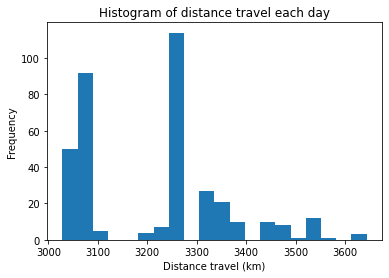

Mean: 3214.2931506849313
Std: 7.513778618777235
95% Confidence interval: [3199.517285729717, 3229.0690156401456]


In [ ]:
class FlexibleTruck(Truck):
    '''
    Subclass of the parent Truck class, with a flexible path that the truck 

    Additional Attributes
    ----------
    shortest_path: dict{int: dict{int: int}}
        A dictionary of the shortest path between any two points in the graph
    max_dist_to_fuel: int
        The furtherest distance from the fuel node in the graph
    '''

    def __init__(self, graph, max_fuel = max_fuel, max_waste = max_waste):
        super().__init__(graph, max_fuel, max_waste)
        self.max_dist_to_fuel = max(self.graph.get_dist_to_fuel(node) for node in self.graph.G.nodes())
        self.shortest_path = dict(nx.all_pairs_dijkstra_path_length(self.graph.G))

    def __repr__(self):
        return "Flexible Truck"

    def run_one_day(self):
        '''
        Run the truck for a day. 

        Parameters
        ----------
        None

        Returns
        ----------
        total_fuel_used: int
            Total fuel used in that day
        '''
        total_fuel_used, cur_loc = self.setup_day()
        visited = set([self.dropoff_node, self.fuel_node])

        while len(visited) < len(self.graph.G.nodes()):
            #sanity check
            if self.current_fuel <= 0:
                raise ValueError("Fuel is below 0. Truck is dead.")
            if self.current_waste > self.max_waste:
                raise ValueError("Waste overflow.")

            logger.info(f"Truck currently at {cur_loc}. Fuel: {self.current_fuel}. Waste: {self.current_waste}")

            #greedy algorithm to go to closest node first
            potential_next_locs = [loc for loc in range(len(self.graph.G.nodes())) if (
                loc not in visited and loc != self.fuel_node 
                and loc != self.dropoff_node and loc != cur_loc
                )]
            dist, next_loc = min([(self.shortest_path[cur_loc][loc], loc) 
                                for loc in potential_next_locs], default = (0, 0))

            #if we don't have enough fuel, refuel first
            if self.current_fuel < self.max_dist_to_fuel + dist + self.graph.get_dist_to_fuel(cur_loc):
                refuel = self.refuel(cur_loc)
                if refuel is False:
                    total_fuel_used, cur_loc = self.setup_day()
                    cur_path_idx = 0
                    continue
                total_fuel_used += refuel
                cur_loc = self.fuel_node
                continue
            
            #if we are at maximum waste capacity, dropoff waste
            if self.current_waste == self.max_waste:
                total_fuel_used += self.dropoff_waste(cur_loc)
                cur_loc = self.dropoff_node
                continue
            
            #travel to next location
            total_fuel_used += dist
            self.current_fuel -= dist

            cur_loc = next_loc

            #remove waste
            waste_remove = min(self.graph.G.nodes[cur_loc]["waste"], self.max_waste - self.current_waste)
            self.graph.G.nodes[cur_loc]["waste"] -= waste_remove
            self.current_waste += waste_remove
            
            #we move on the next index only after we clear all the waste in the location
            if self.graph.G.nodes[cur_loc]["waste"] == 0:
                visited.add(cur_loc)
            
        #remove all waste left
        total_fuel_used += self.dropoff_waste(cur_loc)
        #sanity check
        for node in self.graph.G.nodes():
            if self.graph.G.nodes[node]["waste"] > 0:
                raise ValueError(f"Waste at {node} not removed")

        return total_fuel_used


network = Network()           
truck = FlexibleTruck(network)
truck.run_one_day()

simulation = Simulation(network, truck)
simulation.run(365)
simulation.plot()
simulation.summarize()

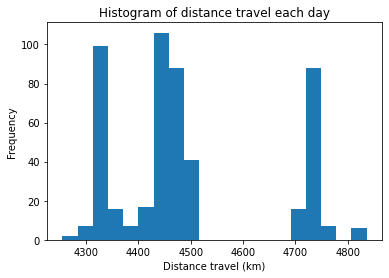

Mean: 4486.69
Std: 6.4458872721643905
95% Confidence interval: [4474.025575825385, 4499.354424174614]


In [ ]:

class Simulation:
    '''
    Run the simulation

    Parameters
    ----------
    network: Network
        The graph network instance
    truck: Truck
        The truck instance

    Attributes
    ----------
    network: Network
        The graph network instance
    truck: Truck
        The truck instance
    day: int
        The number of days in the simulation
    fuel_storage: list[int]
        A list storing how much fuel the truck has used

    '''

    def __init__(self, network, truck):
        self.network = network
        self.truck = truck
        self.day = 0
        self.fuel_storage = []


    def run_one_day(self):
        '''
        Run the simulation for a day. 

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        self.day += 1
        self.network.update_daily_waste()
        fuel_used = self.truck.run_one_day()
        self.fuel_storage.append(fuel_used)

    def run(self, days):
        '''
        Run the simulation for multiple days. 

        Parameters
        ----------
        days: int
            Number of days we want to run the simulation

        Returns
        ----------
        None
        '''
        self.fuel_storage = []
        for i in range(days):
            self.run_one_day()

    def plot(self):
        '''
        Plot the histogram for the fuel used by the truck

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        plt.hist(self.fuel_storage, bins = 20)
        plt.title("Histogram of distance travel each day")
        plt.xlabel("Distance travel (km)")
        plt.ylabel("Frequency")
        plt.show()

    def summarize(self):
        '''
        Get the mean, standard deviation, and lower and upper bound of the 95% 
        confidence interval

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        mean = np.mean(self.fuel_storage)
        std = st.sem(self.fuel_storage)
        lower_bound, upper_bound = st.t.interval(0.95, len(self.fuel_storage)-1, loc=mean, scale=std)
        print(f"Mean: {mean}\nStd: {std}\n95% Confidence interval: [{lower_bound}, {upper_bound}]")

simulation = Simulation(test, test_truck)
simulation.run(500)
simulation.plot()
simulation.summarize()


## Best algorithm for fixed-route truck

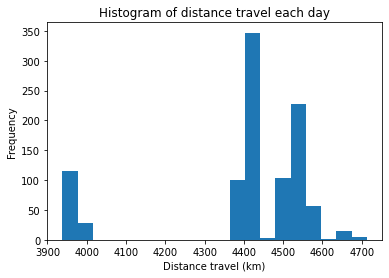

Mean: 4408.586
Std: 5.884000345348738
95% Confidence interval: [4397.039582164999, 4420.132417835001]


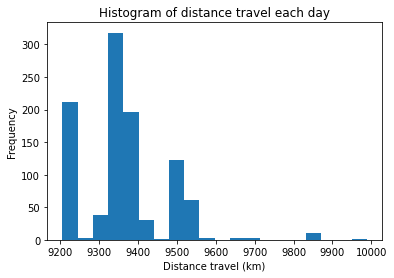

Mean: 9367.945
Std: 3.4726766993860023
95% Confidence interval: [9361.130422531682, 9374.759577468318]


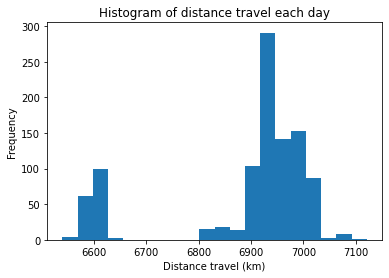

Mean: 6895.278
Std: 4.346871749892101
95% Confidence interval: [6886.747953338957, 6903.808046661044]


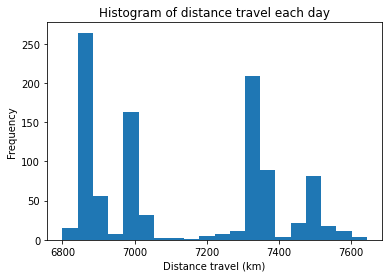

Mean: 7134.587
Std: 7.698851781256069
95% Confidence interval: [7119.4792239465205, 7149.69477605348]


In [ ]:
#trying other algorithm heuristics

def minimize_dist_to_fuel(graph):
    '''
    The algorithm used by the Fixed Truck. It calculates an approximation 
    to the travelling salesman problem with the weights as the distance to fuel

    Parameters
    ----------
    graph: Network
        The Network instance that we use to calculate the path

    Returns
    ----------
    path: list[int]
        A list of the index of location that the truck needs to use to get to all farm nodes
    '''
    for node in graph.G.nodes():
        graph.G.nodes[node]["dist_to_fuel"] = graph.get_dist_to_fuel(node)
    return nx.approximation.traveling_salesman_problem(graph.G, weight = "dist_to_fuel")


def minimize_dist_to_dropoff(graph):
    '''
    The algorithm used by the Fixed Truck. It calculates an approximation 
    to the travelling salesman problem with the weights as the distance to dropoff

    Parameters
    ----------
    graph: Network
        The Network instance that we use to calculate the path

    Returns
    ----------
    path: list[int]
        A list of the index of location that the truck needs to use to get to all farm nodes
    '''
    for node in graph.G.nodes():
        graph.G.nodes[node]["dist_to_dropoff"] = graph.get_dist_to_dropoff(node)
    return nx.approximation.traveling_salesman_problem(graph.G, weight = "dist_to_dropoff")

def maximize_waste(graph):
    '''
    The algorithm used by the Fixed Truck. It calculates an approximation 
    to the travelling salesman problem with the weights as the negative value of waste

    Parameters
    ----------
    graph: Network
        The Network instance that we use to calculate the path

    Returns
    ----------
    path: list[int]
        A list of the index of location that the truck needs to use to get to all farm nodes
    '''
    for node in graph.G.nodes():
        graph.G.nodes[node]["waste_neg"] = -graph.G.nodes[node]["waste"]
    return nx.approximation.traveling_salesman_problem(graph.G, weight = "waste_neg")

for algo in [default_algo, minimize_dist_to_fuel, minimize_dist_to_dropoff, maximize_waste]:
    network = Network()
    truck = FixedTruck(network, algorithm = algo)
    simulation = Simulation(network, truck)
    simulation.run(1000)
    simulation.plot()
    simulation.summarize()

## Comparing Fixed Truck and Flexible Truck

<class '__main__.FixedTruck'>
Mean: 3726.765
Std: 3.521712684935447
95% Confidence interval: [3719.8541971841514, 3733.6758028158483]

<class '__main__.FlexibleTruck'>
Mean: 3330.34
Std: 6.969195081218497
95% Confidence interval: [3316.664059541398, 3344.0159404586025]



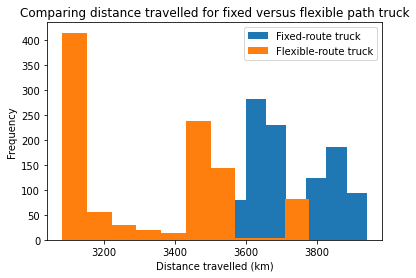

Ttest_indResult(statistic=50.76861487439598, pvalue=0.0)

In [ ]:
network = Network()
fuels = []

for TruckClass in [FixedTruck, FlexibleTruck]:
    truck = TruckClass(network)
    simulation = Simulation(network, truck)
    simulation.run(1000)
    print(TruckClass)
    simulation.summarize()
    print()
    fuels.append(simulation.fuel_storage)

plt.hist(fuels[0], label = "Fixed-route truck")
plt.hist(fuels[1], label = "Flexible-route truck")
plt.xlabel("Distance travelled (km)")
plt.ylabel("Frequency")
plt.title("Comparing distance travelled for fixed versus flexible path truck")
plt.legend()
plt.show()



## Statistical Analysis


In [ ]:
#statistical significance
print(st.ttest_ind(fuels[0], fuels[1], equal_var = False))

#effect size
#taken from https://stackoverflow.com/a/71875070/13808976
def cohend(d1, d2) -> float:
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)

    # return the effect size
    return (u1 - u2) / s

cohend(fuels[0], fuels[1])

Ttest_indResult(statistic=50.76861487439598, pvalue=0.0)


2.270441479653127